### 📘 Financial Analysis Portfolio

**Author:** Rui Carvalho Caseiro     
**LinkedIn:** [https://www.linkedin.com/in/ruicarvalhocaseiro/](https://www.linkedin.com/in/ruicarvalhocaseiro/)  
**GitHub:** [https://github.com/notp1ssed](https://github.com/notp1ssed)  
**Email:** ruicarvalhocaseiro@outlook.pt

*Exploring financial data, building models, and testing strategies through Python and data science.*

# Imports

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import ffn

from MyCustomLibrary.features import get_ROC_vola_adj
from MyCustomLibrary.atw import timer, train_test_split

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

## Data

In [2]:
quotes = pd.read_csv(
    r'D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\000_Local_Pyhton_Packages\MyDataLibrary\bitcoin_full.csv',
    index_col=[0], parse_dates=True)

quotes

,Open,High,Low,Close
Date,,,,
2010-07-17,0.05,0.05,0.05,0.05
2010-07-18,0.05,0.09,0.05,0.09
2010-07-19,0.09,0.09,0.08,0.08
2010-07-20,0.08,0.08,0.07,0.07
2010-07-21,0.07,0.08,0.07,0.08
...,...,...,...,...
2025-04-04,83100.25,84696.15,81670.75,83843.80
2025-04-05,83844.70,84207.02,82377.73,83504.80
2025-04-06,83504.51,83704.72,77097.74,78214.48


In [3]:
quotes.shape

(5374, 4)

In [4]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5374 entries, 2010-07-17 to 2025-04-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5374 non-null   float64
 1   High    5374 non-null   float64
 2   Low     5374 non-null   float64
 3   Close   5374 non-null   float64
dtypes: float64(4)
memory usage: 209.9 KB


In [5]:
quotes.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [6]:
quotes.describe()

,Open,High,Low,Close
count,5374.00,5374.00,5374.00,5374.00
mean,15414.78,15757.01,15051.96,15428.12
std,23001.80,23490.92,22477.17,23014.44
min,0.05,0.05,0.01,0.05
25%,239.00,244.11,236.04,239.32
50%,3967.70,4069.98,3890.57,3974.20
75%,23067.84,23454.45,22683.41,23108.08
max,106147.30,109114.88,105291.73,106146.27


#### Features Engineering

In [7]:
def df_add_alpha_factors(quotes_df: pd.DataFrame) -> pd.DataFrame:
    ''' 
        Input: Feed a SINGLE Level DataFrame with several assets prices
        Output: Get the same Data Frame plus Several indicators for each symbol
    '''
    all_new_columns = []

    close_series = quotes_df['Close']
    high_series = quotes_df['High']
    low_series = quotes_df['Low']

    # TARGET RETURNS FACTORS
    new_columns = {}

    # TREND FACTORS
    for lenght in [20, 50, 100]:
        new_columns[f'MA{lenght}'] = close_series.rolling(window=lenght, min_periods=lenght).mean()
        new_columns[f'EMA{lenght}'] = close_series.ewm(span=lenght, min_periods=lenght, adjust=False).mean()
        new_columns[f'ADX{lenght}'] = ta.adx(high=high_series, low=low_series, close=close_series, length=lenght).iloc[:,0]

        new_columns[f'RollMax{lenght}'] = high_series.rolling(lenght).max()
        new_columns[f'RollMin{lenght}'] = low_series.rolling(lenght).min()
       

    # VOLA FACTORS
    for lenght in [20, 50, 100]:
        new_columns[f'Vola{lenght}'] = close_series.pct_change().ewm(span=lenght, min_periods=lenght).std()
        new_columns[f'ATR{lenght}'] = ta.atr(high=high_series, low=low_series, close=close_series, length=lenght)


    # MOMENTUM FACTORS
    for lenght in [10, 30, 200]:
        new_columns[f'ROC{lenght}'] = get_ROC_vola_adj(close_series, lenght)
        new_columns[f'MOM{lenght}'] = close_series.diff(lenght)
        
        new_columns[f'RSI{lenght}'] = ta.rsi(close_series, length=lenght)

        stoch_rsi = ta.stoch(high=quotes['High'], low=quotes['Low'], close=quotes['Close'], k=lenght)
        new_columns[f'STOK{lenght}'] = stoch_rsi.iloc[:,0]
        new_columns[f'STOD{lenght}'] = stoch_rsi.iloc[:,1]
        

    # TARGET RETURNS FACTORS
    for lookback in [5, 15, 30, 90]:
        new_columns[f'target_{lookback}'] = close_series.pct_change(lookback).shift(-lookback)

    # Convert the dictionary to a DataFrame with MultiIndex columns
    symbol_df = pd.DataFrame(new_columns)
    all_new_columns.append(symbol_df)

    # Concatenate all new columns horizontally
    result_df = pd.concat([quotes_df] + all_new_columns, axis=1)
        
    return result_df

df = df_add_alpha_factors(quotes)

In [8]:
df.shape

(5374, 44)

In [9]:
df.dropna().shape

(5081, 44)

In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'MA20', 'EMA20', 'ADX20', 'RollMax20',
       'RollMin20', 'MA50', 'EMA50', 'ADX50', 'RollMax50', 'RollMin50',
       'MA100', 'EMA100', 'ADX100', 'RollMax100', 'RollMin100', 'Vola20',
       'ATR20', 'Vola50', 'ATR50', 'Vola100', 'ATR100', 'ROC10', 'MOM10',
       'RSI10', 'STOK10', 'STOD10', 'ROC30', 'MOM30', 'RSI30', 'STOK30',
       'STOD30', 'ROC200', 'MOM200', 'RSI200', 'STOK200', 'STOD200',
       'target_5', 'target_15', 'target_30', 'target_90'],
      dtype='object')

#### Create Different sets of data

In [11]:
df.dropna(inplace=True)
X = df[['EMA20', 'ADX50', 'Vola50', 'ROC30', 'RSI30']]
y = df['target_5']

X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)

#### Linear Regression Training

In [12]:
from sklearn.linear_model import LinearRegression

# Initialize the class
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

LinearRegression()

#### Linear Regression predictions

In [13]:
y_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAE: 0.04822058548898882
MSE: 0.004263881749407646
R2: -0.06349344990198724


In [15]:
y_pred_signals = np.sign(y_pred)
y_pred_signals

array([ 1., -1., -1., ..., -1., -1., -1.])

#### Backtest Signals

In [ ]:
backtestdata = pd.DataFrame(index=X_test.index)

_, backtestdata['Market Price'] = train_test_split(df['Close'])

backtestdata['Market Returns'] = np.log(backtestdata['Market Price']/backtestdata['Market Price'].shift(1))

backtestdata['signal_pred'] = np.sign(y_pred)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

backtestdata.head()

,Market Price,Market Returns,signal_pred,Strategy Returns
Date,,,,
2022-03-29,47465.73,NaN,1.00,NaN
2022-03-30,47062.66,-0.01,-1.00,-0.01
2022-03-31,45538.68,-0.03,-1.00,0.03
2022-04-01,46281.64,0.02,-1.00,-0.02
2022-04-02,45868.95,-0.01,-1.00,0.01


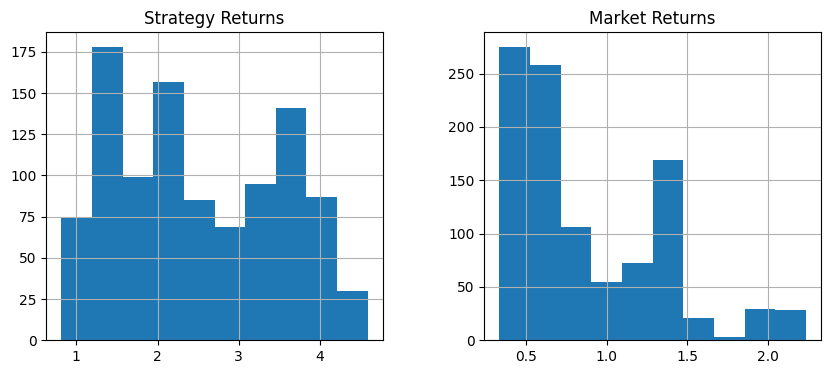

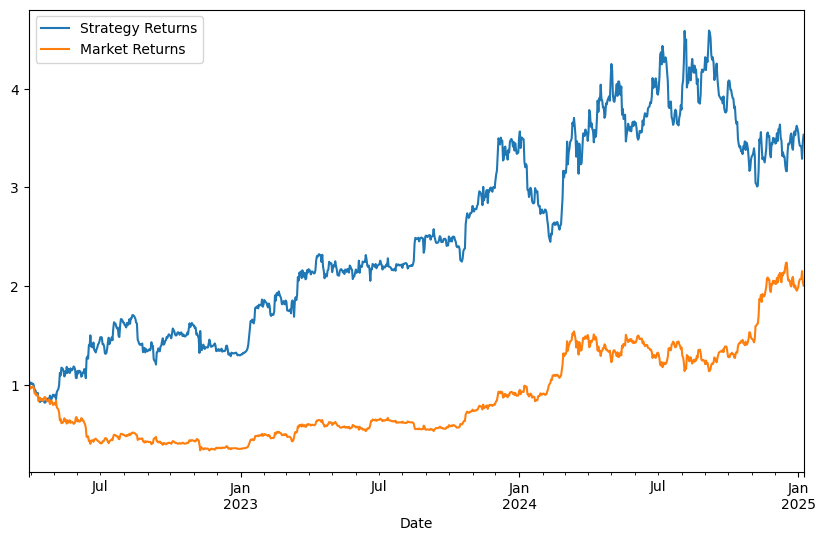

In [17]:
equity_curves = backtestdata[['Strategy Returns','Market Returns']].cumsum().apply(np.exp)

equity_curves.hist(figsize=(10,4))
equity_curves.plot(figsize=(10,6));

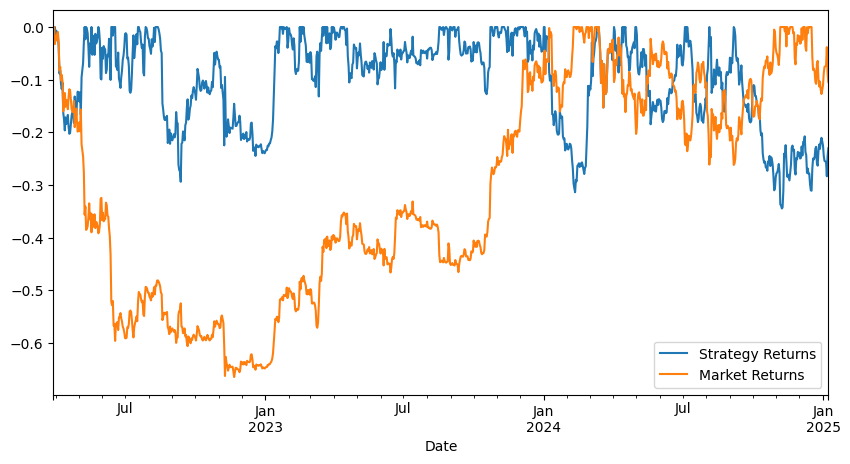

In [18]:
# what about the drawdowns?
ax = equity_curves.to_drawdown_series().plot(figsize=(10, 5))

In [19]:
# ok now what about some performance metrics?
stats = equity_curves.calc_stats()
stats.display()

Stat                 Strategy Returns    Market Returns
-------------------  ------------------  ----------------
Start                2022-03-30          2022-03-30
End                  2025-01-08          2025-01-08
Risk-free rate       0.00%               0.00%

Total Return         256.16%             101.95%
Daily Sharpe         0.93                0.62
Daily Sortino        1.69                1.03
CAGR                 57.95%              28.78%
Max Drawdown         -34.45%             -66.45%
Calmar Ratio         1.68                0.43

MTD                  -1.70%              1.73%
3m                   -9.38%              52.97%
6m                   -19.10%             67.61%
YTD                  -1.70%              1.73%
1Y                   8.32%               102.35%
3Y (ann.)            57.95%              28.78%
5Y (ann.)            -                   -
10Y (ann.)           -                   -
Since Incep. (ann.)  57.95%              28.78%

Daily Sharpe         0.93  

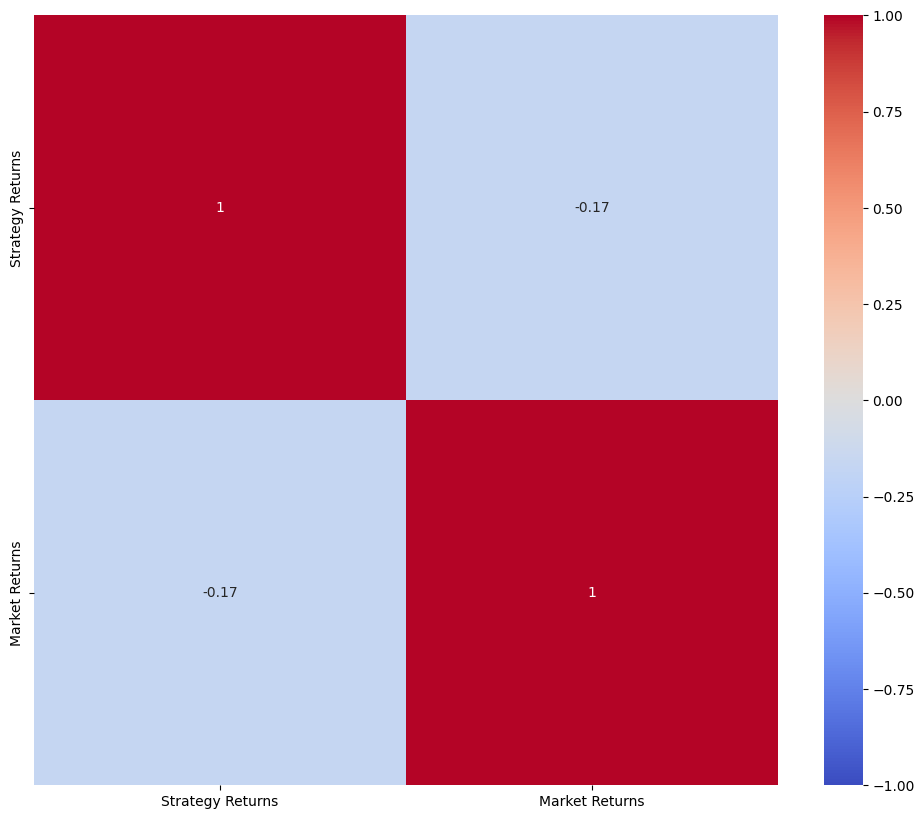

In [20]:
from MyCustomLibrary.main import correlation_map

correlation_map(equity_curves)